**Install**:
```
pip install -U langchain \
    langgraph==0.1.19 \
    langchain_openai \
    langchainhub \
    langchain_experimental
```

In [1]:
import os
from dotenv import load_dotenv
load_dotenv('./.env')

os.environ["LANGCHAIN_PROJECT"] = "Demo LangGraph 003"

### Model

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

### Tools

In [3]:
from typing import Annotated, List, Tuple, Union
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
import random

python_repl_tool = PythonREPLTool()

In [4]:
@tool("lower_case", return_direct=True)
def to_lower_case(input:str) -> str:
    """Retorna a entrada em minúsculas"""
    return input.lower()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Retorna um número entre 0 e 100, mostrando a palavra 'random'"""
    return random.randint(0, 100)

tools = [to_lower_case, random_number_maker, python_repl_tool]

### Helper Utils

In [5]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [6]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Supervisor

In [7]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Lotto_Manager", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

### Agent and Graph State

In [8]:
import operator
import functools
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

lotto_agent = create_agent(llm, tools, "You are a senior lotto manager. you run the lotto and get random numbers")
lotto_node = functools.partial(agent_node, agent=lotto_agent, name="Lotto_Manager")

code_agent = create_agent(llm, [python_repl_tool], "You may generate safe python code to analyze data and generate charts using matplotlib.")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Lotto_Manager", lotto_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

### Edges

In [9]:
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.set_entry_point("supervisor")

graph = workflow.compile()

### Run

{'supervisor': {'next': 'Lotto_Manager'}}
----


Python REPL can execute arbitrary code. Use with caution.


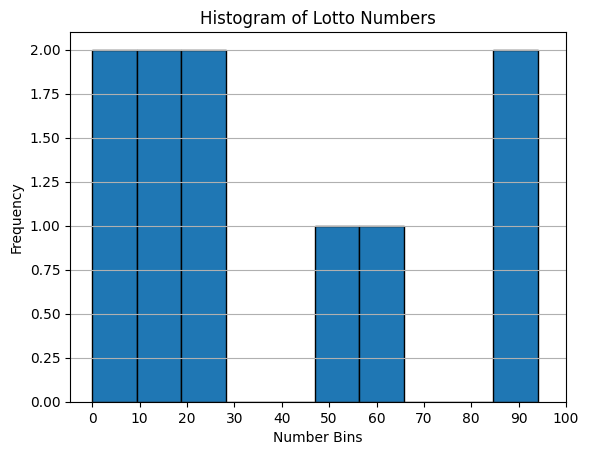

TypeError: Object of type CallbackManagerForToolRun is not JSON serializable

In [10]:
config = {"recursion_limit": 20}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
):
    if "__end__" not in s:
        print(s)
        print("----")